# System State in the Temperature-Entropy Diagram
There are Quantum Engines (QEs)  working with non-thermal quantum states.
We want to see if we can manipulate Squeezed States of the Cavity

In [30]:
import glob
from IPython.display import display, Image
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
from qutip.visualization import plot_fock_distribution, plot_wigner

import tqdm

import uuid
import json
import os

from thermophaseonium.utilities.make_gif import create_gif
from thermophaseonium.utilities.states import Cavity, Ancilla

SEED = 42
rng = np.random.default_rng(SEED)

OMEGA = 0.5  # Interaction strength
N = 300  # Maximum number of dimensions

INTERACTION_TIME = 0.02
T_MAX = 100
TIMESTEPS = np.linspace(0, T_MAX, int(T_MAX / INTERACTION_TIME))
print(f"Total of {len(TIMESTEPS)} timesteps from 0 to {T_MAX} with dt = {INTERACTION_TIME}")

FRAMES = TIMESTEPS[::int(len(TIMESTEPS) / 30)]
print(f"{len(FRAMES)} frames to be plotted")
FRAMES_PATH = "../visualization/dynamics/wigner"

Total of 5000 timesteps from 0 to 100 with dt = 0.02
31 frames to be plotted


In [31]:
def create_isobaric_ancilla():
    """
    This is an ancilla that only exchange heat with the system without doing work
    :return: 
    """
    alpha = np.sqrt(0.4)
    heat_amplitude = (1 - alpha**2) / 2
    chi01_phase = np.pi * 0
    chi02_phase = np.pi * 1
    chi12_phase = np.pi * 0
    chi01 = np.cos(chi01_phase) + 1j * np.sin(chi01_phase)
    chi02 = np.cos(chi02_phase) + 1j * np.sin(chi02_phase)
    chi12 = heat_amplitude * (np.cos(chi12_phase) + 1j * np.sin(chi12_phase))
    
    ancilla = Ancilla([
        [alpha**2, chi01, chi02],
        [chi01.conjugate(), (1 - alpha**2)/2, chi12],
        [chi02.conjugate(), chi12.conjugate(), (1 - alpha**2)/2]
    ])
    
    return ancilla


def create_adiabatic_ancilla():
    """
    This is an ancilla that only do work on the system without exchanging heat
    :return: 
    """
    alpha = np.sqrt(0.4)
    work_amplitude = 1e-2
    chi01_phase = np.pi * 0.5
    chi02_phase = np.pi * 0.5
    # chi12_phase = np.pi * 0.5
    chi01 = work_amplitude * (np.cos(chi01_phase) + 1j * np.sin(chi01_phase))
    chi02 = work_amplitude * (np.cos(chi02_phase) + 1j * np.sin(chi02_phase))
    # chi12 = ( np.cos(chi12_phase) + 1j * np.sin(chi12_phase) )
    chi12 = 0 + 1j
    ancilla = Ancilla([
        [alpha**2, chi01, chi02],
        [chi01.conjugate(), (1 - alpha**2)/2, chi12],
        [chi02.conjugate(), chi12.conjugate(), (1 - alpha**2)/2]
    ])
    
    return ancilla

ancilla = create_adiabatic_ancilla()
print(f"Stable temperature: {ancilla.stable_temperature}")
ancilla

Stable temperature: 2.059699076913792


Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[4.000000e-01+0.j   6.123234e-19+0.01j 6.123234e-19+0.01j]
 [6.123234e-19-0.01j 3.000000e-01+0.j   0.000000e+00+1.j  ]
 [6.123234e-19-0.01j 0.000000e+00-1.j   3.000000e-01+0.j  ]]

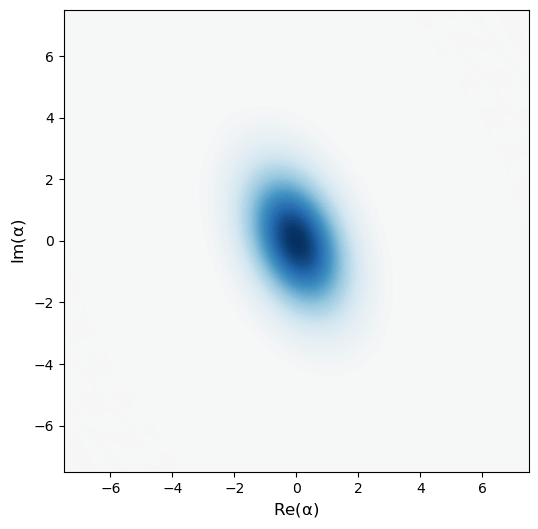

(<Figure size 600x600 with 1 Axes>,
 <Axes: xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>)

In [32]:
def squeezing_operator(angle, squeeze, ndims):
    squeeze_param = squeeze * np.exp(1j * angle)
    a = qt.destroy(ndims)
    return ((squeeze_param.conjugate() * a ** 2 - squeeze_param * a.dag() ** 2 ) / 2).expm()

n_photons = 1
system = qt.thermal_dm(N, n_photons)
squeeze_op = squeezing_operator(np.pi / 4, 0.25, N)
squeezed_system = squeeze_op * system * squeeze_op.dag()
squeezed_system = Cavity(squeezed_system, hermitian=False)

squeezed_system.plot_wigner()

## Evolution

In [33]:
def H_work(ancilla, omega=OMEGA):
    chi01 = ancilla.chi01
    chi02 = ancilla.chi02
    a = qt.destroy(N)
    upshift = (chi01 + chi02) * a.dag()
    return omega * (upshift + upshift.dag())

In [34]:
def D(op1, rho, op2=None):
    if op2 is None:
        op2 = op1
    return op1 * rho * op2.dag() - qt.commutator(op2.dag() * op1, rho, kind='anti') / 2

In [35]:
def onestep_evolution(rho, eta, dt=INTERACTION_TIME, o=OMEGA):
    work = 1j * o * dt * qt.commutator(H_work(eta), rho)
    heat1 = eta.ga * ( o * dt ) ** 2 * D(qt.create(N), rho)
    heat2 = eta.gb * ( o * dt ) ** 2 * D(qt.destroy(N), rho)
    rho_new = rho + work + heat1 + heat2
    return rho_new

In [36]:
def hilbert_is_good(rho, threshold=1e-6):
    """
    Check if the last element of the density matrix is almost null
    """
    return 0 <= abs(rho[-1, -1]) < threshold

In [43]:
def new_ancilla(ancilla, method='static', **kwargs):
    if method == 'static':
        return ancilla
    elif method == 'rotating':
        phis = np.linspace(0, 2 * np.pi, kwargs.get('timesteps', 10))
        ancilla.chi01 = 0.1 * (np.cos(phis[kwargs.get('step', -1)]) + 1j * np.sin(phis[kwargs.get('step', -1)]))
        ancilla.chi02 = 0.1 * (np.cos(phis[kwargs.get('step', -1)]) + 1j * np.sin(phis[kwargs.get('step', -1)]))
        return ancilla
    else:
        raise ValueError(f"Method {method} not recognized")


In [44]:
def stroke(kind, system, timesteps):
    if kind == 'adiabatic':
        ancilla = create_adiabatic_ancilla()
    elif kind == 'isobaric':
        ancilla = create_isobaric_ancilla()
    else:
        raise ValueError(f"Kind {kind} not recognized")
    
    temperature_evolution = np.zeros(len(timesteps))
    entropy_evolution = np.zeros(len(timesteps))
    time_evolution = np.zeros(len(timesteps))
    
    for k, t in enumerate(tqdm.tqdm(timesteps, desc=f"{kind.capitalize()} stroke")):
        eta_k = ancilla
        time_evolution[k] = t
        try:
            rho_new =  Cavity(onestep_evolution(system, eta_k))
        except ValueError as e:
            print(f"Error in computing the evolution at step {k} with t = {t}: {e}")
            # Return the last good state and the evolution up to this point
            return Cavity(system), temperature_evolution[:k], entropy_evolution[:k], time_evolution[:k]
    
        temperature_evolution[k] = rho_new.temperature
        entropy_evolution[k] = rho_new.entropy
    
        if not hilbert_is_good(system):
            print(f"Approximation no more valid at step {k} with t = {t}")
            return Cavity(system), temperature_evolution, entropy_evolution, time_evolution
        else:
            # Update the state
            system = Cavity(rho_new)
    
    return system, temperature_evolution, entropy_evolution, time_evolution

In [47]:
def evolve(system, timesteps, beam_type='static', gif_name='wigner'):
    time_evolution = np.zeros(len(timesteps))
    
    for k, t in enumerate(tqdm.tqdm(timesteps)):
        eta_k = new_ancilla(ancilla, beam_type, timesteps=len(timesteps), step=k)
        time_evolution[k] = t
        try:
            rho_new =  Cavity(onestep_evolution(system, eta_k), hermitian=False)
        except ValueError as e:
            print(f"Error in computing the evolution at step {k} with t = {t}: {e}")
            # Return the last good state and the evolution up to this point
            return Cavity(system, hermitian=False), time_evolution[:k]

        if not hilbert_is_good(system):
            print(f"Approximation no more valid at step {k} with t = {t}")
            return Cavity(system, hermitian=False), time_evolution
        else:
            # Update the state
            system = Cavity(rho_new, hermitian=False)
        
        if t in FRAMES:
            system.plot_wigner(
                title=f"Wigner function (t = {t:.2f})",
                show=False, 
                alpha_max=10,
                path=f"{FRAMES_PATH}/{k}_{gif_name}.png")
            
    return system, time_evolution

In [46]:
rho = squeezed_system
gif_name = 'wigner_squeezed_rotating'
rho, time_evolution = evolve(rho, TIMESTEPS, beam_type='rotating', gif_name=gif_name)

100%|██████████| 5000/5000 [04:20<00:00, 19.21it/s]


TypeError: cannot unpack non-iterable NoneType object

In [48]:
gif_name = create_gif(gif_name, FRAMES_PATH)

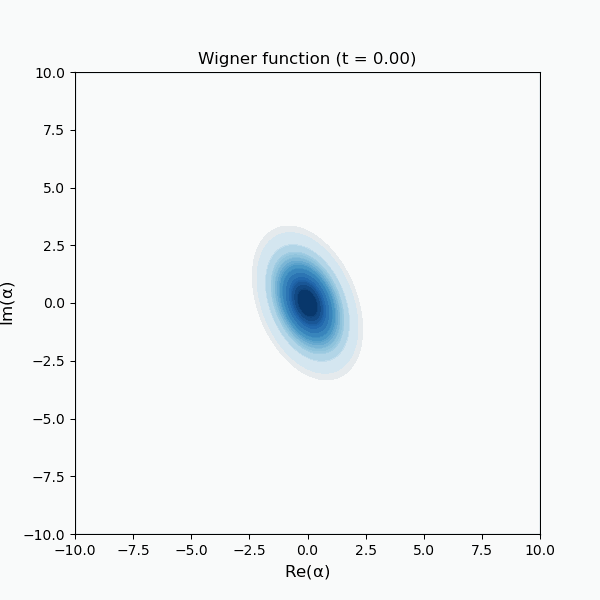

wigner_evolution_wigner_squeezed_rotating.gif


In [49]:
display(Image(filename=f"{FRAMES_PATH}/{gif_name}", width=10, height=10))
print(gif_name)